In [41]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from dataset import DataSet
import pandas as pd
import glob
%load_ext autoreload
np.random.seed(2) 
torch.manual_seed(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%autoreload

In [63]:
lcs = utils.get_data('../../datasets/ZTF_MCG+08-11-011_g', test_split=0.0, min_length=25, sep=',', start_col=1)


found 1 for band='g'
max time:  1122.0078
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(1, 1, 170, 3)
train size: 1, valid size: 1, test size: 0


In [116]:
lcs = utils.get_data('../../datasets/ZTF_MCG+08-11-011_r', test_split=0.0, min_length=25, sep=',', start_col=1)

found 1 for band='r'
max time:  1471.0078
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(1, 1, 245, 3)
train size: 1, valid size: 1, test size: 0


In [117]:
np.median(lcs.dataset[0,0,1:,0] - lcs.dataset[0,0,:-1,0])

1.9140625

In [115]:
net,optimizer,scheduler,lrs, args, epoch, losses = utils.load_checkpoint('../../datasets/ZTF_MCG+08-11-011_g0.11788289248943329.h5', lcs.data_obj)


TypeError: cannot unpack non-iterable NoneType object

In [85]:
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device='mps')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.77it/s]


In [86]:
## take samples from qz, decode separately, then average the interpolations 
n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:])

In [87]:
zs.shape

(10, 1, 16, 64)

In [88]:
# choose target time points
target_tp = np.arange(0,1500,step=3, dtype=np.float32)
# format it... want (num exs x num bands x num tps)
#target_tp = lcs.dataset[:,0,:,0].flatten()
target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(lcs.dataset.shape[0],axis=0)

In [89]:
interps = np.array([utils.decode(net,z[:10],disc_path[:10],target_tp[:10]) for z in zs])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.69it/s]


In [90]:
interps.shape

(10, 1, 1, 500, 3)

In [91]:
t = interps[0,:,:,:,0]
y_avg = interps[:,:,:,:,1].mean(0)
yerr_avg = interps[:,:,:,:,2].mean(0)
intps = np.concatenate((t[np.newaxis],y_avg[np.newaxis],yerr_avg[np.newaxis]),axis=0).transpose(1,2,3,0)

## UNNORMALIZE

In [92]:
for i, object_lcs in enumerate(lcs.unnormalized_data[:10]): 
    min_t = 1000000
    for lc in object_lcs:
        if lc[:,1].any():
            if lc[0,0] < min_t:
                min_t = lc[0,0]
                
    for j, lc in enumerate(object_lcs):
        if lc[:,1].any():
            mean = np.mean(lc[:,1])
            std = np.std(lc[:,1])
            intps[i,j,:,0] = intps[i,j,:,0] + min_t
            intps[i,j,:,1] = (intps[i,j,:,1] * std) + mean  
            intps[i,j,:,2] = (intps[i,j,:,2] * std)


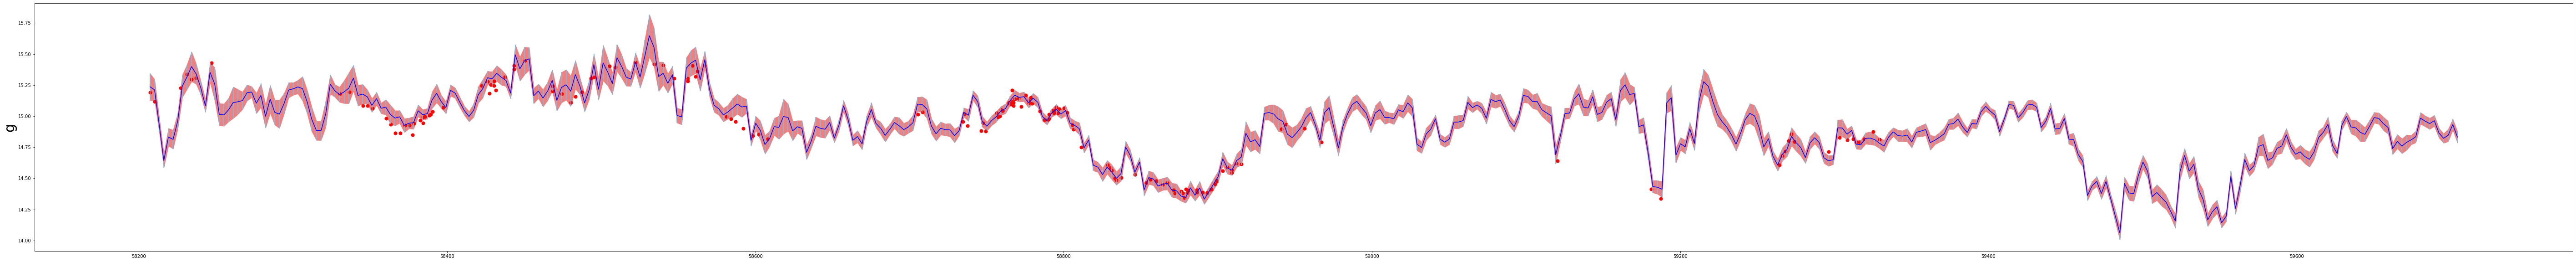

In [93]:
plt.rcParams['figure.figsize']=(100,10)
t=intps[0,0,:,0]
y=intps[:,0,:,1].mean(0)
yerr=intps[:,0,:,2].mean(0)
plt.fill_between(t,y-yerr,y+yerr, label='error envelope',color='lightcoral')
plt.errorbar(t,y,yerr=yerr, c='blue', ecolor='#65c9f7', label='prediction')
plt.ylabel(lcs.bands[0],fontsize=30)
#ax[band].scatter(t,y)
if lcs.unnormalized_data[0][band][:,1].any(): # not missing light curves
    plt.scatter(lcs.unnormalized_data[0][band][:,0], lcs.unnormalized_data[0][band][:,1],marker='o',color='r',s=50,label='actual')

AttributeError: 'numpy.ndarray' object has no attribute 'fill_between'

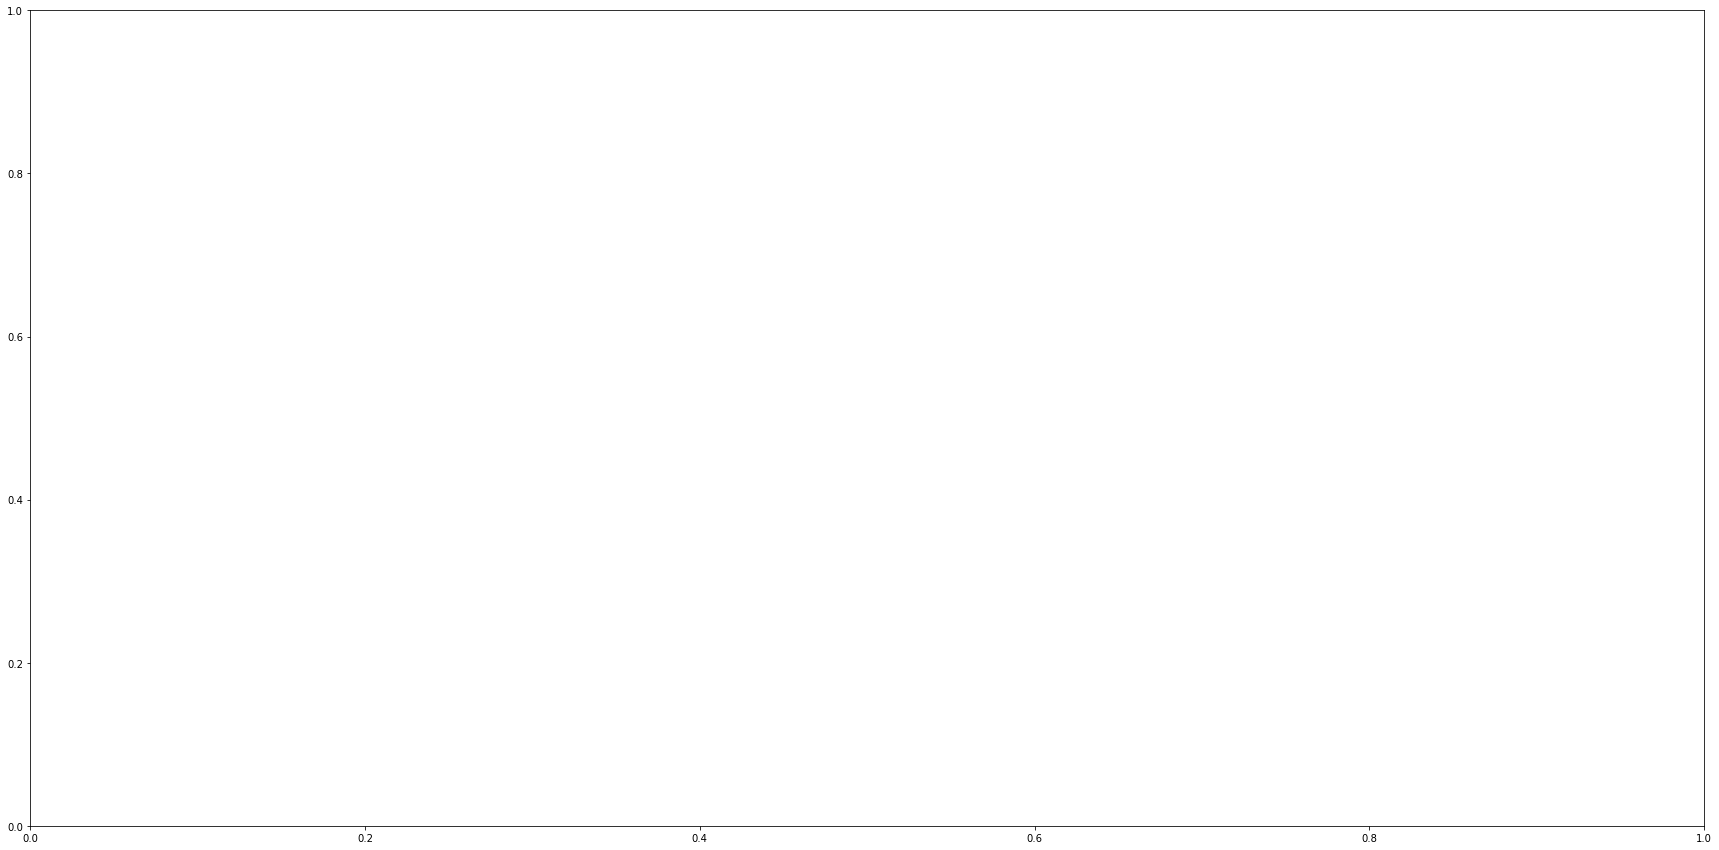

In [31]:
dims = len(lcs.bands)
figsize=(30,15)
fig,ax = plt.subplots(dims,figsize=figsize,squeeze=False)
for i, band in enumerate([0]):
    t=intps[0,band,:,0]
    y=intps[:,band,:,1].mean(0)
    yerr=intps[:,band,:,2].mean(0)
    ax[0].fill_between(t,y-yerr,y+yerr, label='error envelope',color='lightcoral')
    ax[0].errorbar(t,y,yerr=yerr, c='blue', ecolor='#65c9f7', label='prediction')
    ax[0].set_ylabel(lcs.bands[band],fontsize=30)
    #ax[band].scatter(t,y)
    if lcs.unnormalized_data[0][band][:,1].any(): # not missing light curves
        ax.scatter(lcs.unnormalized_data[0][band][:,0], lcs.unnormalized_data[0][band][:,1])
plt.subplots_adjust(wspace=0, hspace=0)    

In [74]:
save_folder = 'gri_interps'

if not os.path.isdir(save_folder): os.mkdir(save_folder)

obj_names = lcs.valid_files_df.index


for i in range(len(interps)):
    for j,band in enumerate(lcs.bands):
        np.savetxt(os.path.join(save_folder,f'{obj_names[i]}_{band}'), interps[i,j])